In [1]:
import numpy as np
#from numpy.random import choice
import matplotlib.pyplot as plt

### Getting basic Cherenkov light source for chroma
Based off of Soud's code at https://github.com/soudk/phys512/blob/master/project_cherenkov/NumbaCherenkov.ipynb

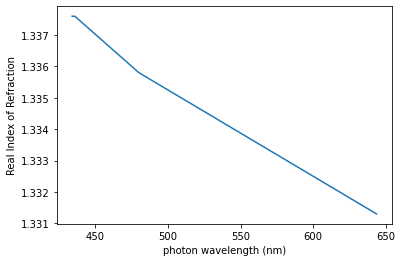

In [6]:
#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index of water from Segelstein, David J. The complex refractive index of water. Diss. University of Missouri--Kansas City, 1981.
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

#plt.plot(energies, n)

wavelengths = 1239.8/energies

freq = 3e17/wavelengths

#Only take the ~near visible range (where photomultiplier tubes are sensitive). 
#This is the tail of the Cherenkov emission spectrum.
cut = [3,7]
freq = freq[cut[0]:cut[1]]
wavelengths=wavelengths[cut[0]:cut[1]]
energies=energies[cut[0]:cut[1]]
n=n[cut[0]:cut[1]]

plt.plot(wavelengths, n)
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')
plt.show()

In [2]:
def propagateChere_init(parentPtcl):
    
    parentMomentum = np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])
    parentEntryPosition = np.array([parentPtcl['x'], parentPtcl['y'], parentPtcl['z']])
    
    parentEndPosition = calc_intersect_OD_photon(parentPtcl)
    
    dx, dy, dz = parentEndPosition[0] - parentEntryPosition[0], parentEndPosition[1] - parentEntryPosition[1], parentEndPosition[2] - parentEntryPosition[2]
    
    #print(parentEntryPosition)
    #print(parentEndPosition)
    trackLength = np.sqrt(dx*dx+dy*dy+dz*dz)
    
    #Note now the muon has moved to it's final position
    
    photonsPerCm=100 #this is set by the physics in the Frank-Tamm formula
    numPhotons = int(trackLength*photonsPerCm)
    
    photons = np.zeros(numPhotons, dtype=ptcl) #output array of photons, can't be parallelized with njit :(
    #photons=np.zeros(numPhotons)
    #assert 1==0
    for i in prange(numPhotons):
        
        numStepsAway = np.random.rand()*trackLength #pick a random point on the track
        
        #photon position
        photons[i]['x']=parentEntryPosition[0]+numStepsAway*parentPtcl['px'] 
        photons[i]['y']=  parentEntryPosition[1]+numStepsAway*parentPtcl['py']
        photons[i]['z'] = parentEntryPosition[2]+numStepsAway*parentPtcl['pz']

        momentum=np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])

        #First, rotate relative to z axis by Cherenkov angle
        c, s = np.cos(thetaRel), np.sin(thetaRel) #cos and sine
        ux, uy, uz = np.cross(parentMomentum, [0.,0.,1.0]) #Need to rotate around axis out of page/into page
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        #momentum= np.dot(R, momentum)

        #Now rotate random amount of phi about axis of parent trajectory
        phi=np.random.sample()*np.pi*2.0
        c, s = np.cos(phi), np.sin(phi) #cos and sine
        ux, uy, uz = parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        
        #Photon momentum set sow now leave track in a cherenkov cone 
        photons[i]['px'], photons[i]['py'], photons[i]['pz'] = momentum[0], momentum[1], momentum[2]
        
        #Deal with the intersection/photon hit here
        calc_intersect_OD_photon(photons[i])
        i+=1
        
    #Return the photon hit positions - I want just their initial positions
    return photons

In [3]:
#Define custom data type here for particles
ptcl = np.dtype({'names':['x', 'y', 'z', 'px', 'py', 'pz', 'tracklength'], 
                 'formats':[np.double, np.double, np.double, np.double, np.double, np.double, np.double]})

In [12]:
numMuons = 1
muon = np.zeros(numMuons, dtype=ptcl)

muon['x'] = 1.0

muon['px'] = 10.0

print(muon[0])

(1., 0., 0., 10., 0., 0., 0.)


In [13]:
propagateChere_init(muon)

NameError: name 'calc_intersect_OD_photon' is not defined